# Normality Analysis of Numeric Features

This notebook analyzes the normality of numeric columns in our dataset. For linear models, having normally distributed features can improve model performance. We will:
1. Test for normality using Shapiro-Wilk test (p < 5%)
2. Visualize distributions using Q-Q plots
3. Apply transformations where needed to achieve normality

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import shapiro

import warnings
warnings.filterwarnings('ignore')

sns.set_theme()

### Load and Prepare Data

In [2]:
DATA_DIR = './Data/'
FILE = 'spotify_tracks_kaggle_weekly.csv'

In [3]:
df = pd.read_csv(DATA_DIR + FILE)

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

print(f"Analyzing {len(numeric_cols)} numeric columns:")
print(numeric_cols)

Analyzing 15 numeric columns:
Index(['year', 'popularity', 'acousticness', 'danceability', 'duration_ms',
       'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')


### Helper Functions for Normality Analysis

In [4]:
def plot_distribution_and_qq(data, column, fig_size=(12, 4)):
    """Create distribution plot and Q-Q plot for a given column."""
    plt.figure(figsize=fig_size)
    
    plt.subplot(1, 2, 1)
    
    values = data[column].dropna()
    skew = stats.skew(values)
    
    if abs(skew) > 2: # instrumentallness was hard to see
        sns.histplot(data=data, x=column, kde=True)
        plt.yscale('log')
        plt.title(f'Distribution of {column}\n(log scale, skewness: {skew:.2f})')
    else:
        sns.histplot(data=data, x=column, kde=True)
        plt.title(f'Distribution of {column}\n(skewness: {skew:.2f})')
    
    plt.subplot(1, 2, 2)
    stats.probplot(data[column].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {column}')
    
    plt.tight_layout()
    plt.show()

def test_normality(data, column):
    values = data[column].dropna()
    print(f"\nTesting normality for {column}")
    print(f"Sample size: {len(values)}")
    print(f"Range: {values.min()} to {values.max()}")
    print(f"Mean: {values.mean():.2f}, Std: {values.std():.2f}")
    
    # Shapiro-Wilk test works best with sample size between 3 and 5000
    if len(values) > 5000:
        values = values.sample(5000, random_state=42)
    
    statistic, p_value = shapiro(values)
    print(f"Shapiro test statistic: {statistic:.4f}, p-value: {p_value:.4e}")
    return p_value

def suggest_transformation(data, column, original_p_value):
    values = data[column].dropna()
    
    transformations = {
        'log': lambda x: np.log1p(x - x.min() + 1) if x.min() <= 0 else np.log1p(x),
        'sqrt': lambda x: np.sqrt(x - x.min() + 1) if x.min() <= 0 else np.sqrt(x),
        'box-cox': lambda x: stats.boxcox(x - x.min() + 1)[0] if x.min() <= 0 else stats.boxcox(x)[0],
        'yeo-johnson': lambda x: stats.yeojohnson(x)[0]
    }
    
    results = {'original': original_p_value}
    transformed_data = {}
    
    for name, transform in transformations.items():
        try:
            print(f"\nTrying {name} transformation...")
            transformed = transform(values)
            if np.all(np.isfinite(transformed)):
                p_value = shapiro(transformed)[1]
                print(f"{name} transformation p-value: {p_value:.4e}")
                results[name] = p_value
                transformed_data[name] = transformed
            else:
                print(f"{name} transformation produced invalid values")
        except Exception as e:
            print(f"Error with {name} transformation: {str(e)}")
            continue
    
    best_transform = max(results.items(), key=lambda x: x[1])
    return best_transform, transformed_data.get(best_transform[0])

### Analyze Each Numeric Column


Analyzing year...

Original distribution:


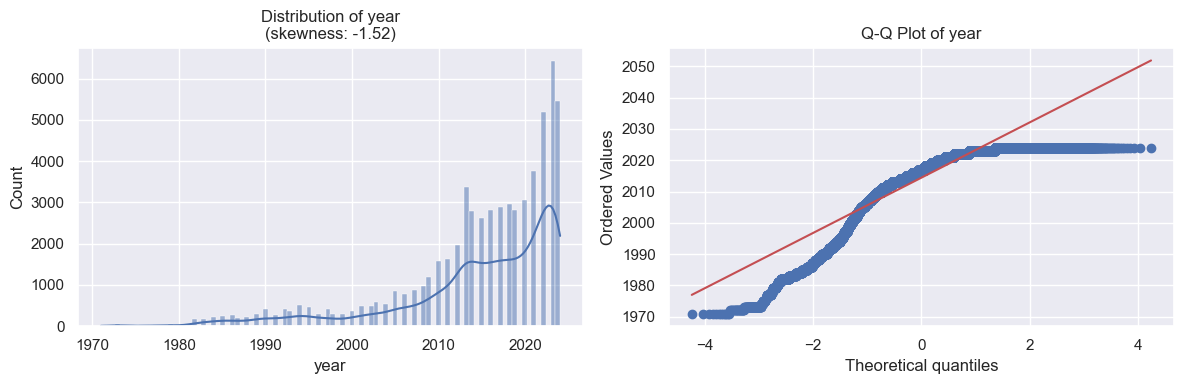


Testing normality for year
Sample size: 62317
Range: 1971 to 2024
Mean: 2014.43, Std: 9.65
Shapiro test statistic: 0.8377, p-value: 1.0451e-57

Data is not normally distributed. Trying transformations...

Trying log transformation...
log transformation p-value: 6.2415e-115

Trying sqrt transformation...
sqrt transformation p-value: 8.7064e-115

Trying box-cox transformation...
box-cox transformation p-value: 7.9229e-91

Trying yeo-johnson transformation...
yeo-johnson transformation p-value: 9.3001e-106
Best transformation: original (p-value: 1.0451e-57)

Analyzing popularity...

Original distribution:


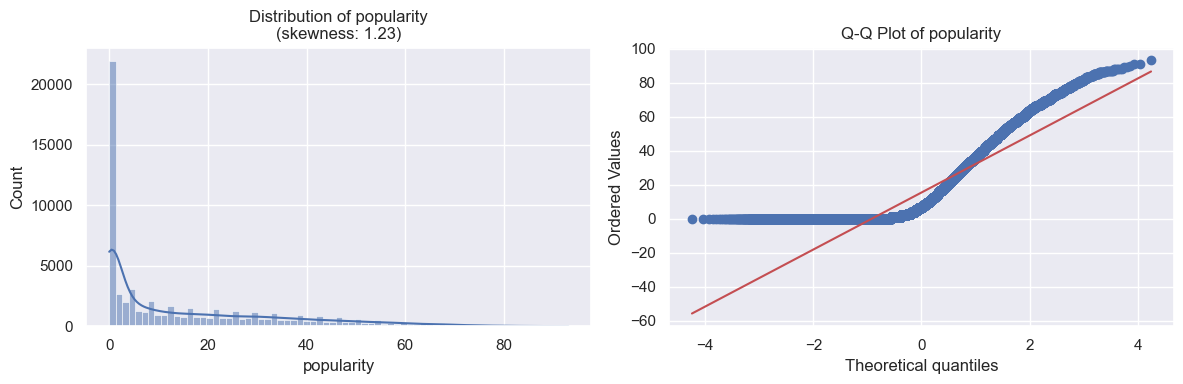


Testing normality for popularity
Sample size: 62317
Range: 0 to 93
Mean: 15.36, Std: 18.63
Shapiro test statistic: 0.8096, p-value: 1.1526e-60

Data is not normally distributed. Trying transformations...

Trying log transformation...
log transformation p-value: 3.7956e-106

Trying sqrt transformation...
sqrt transformation p-value: 4.7757e-106

Trying box-cox transformation...
box-cox transformation p-value: 1.9923e-106

Trying yeo-johnson transformation...
yeo-johnson transformation p-value: 1.9923e-106
Best transformation: original (p-value: 1.1526e-60)

Analyzing acousticness...

Original distribution:


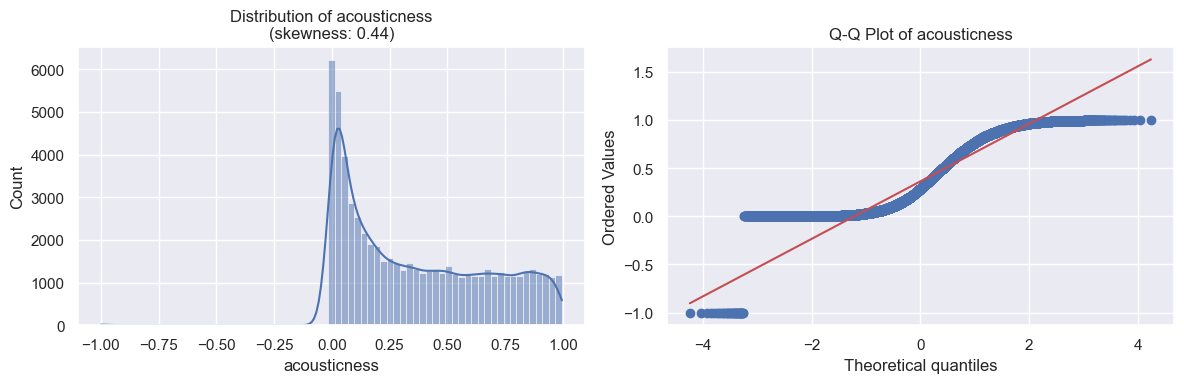


Testing normality for acousticness
Sample size: 62317
Range: -1.0 to 0.996
Mean: 0.36, Std: 0.31
Shapiro test statistic: 0.9027, p-value: 9.3100e-49

Data is not normally distributed. Trying transformations...

Trying log transformation...
log transformation p-value: 8.0507e-101

Trying sqrt transformation...
sqrt transformation p-value: 5.1754e-101

Trying box-cox transformation...
box-cox transformation p-value: 5.6844e-102

Trying yeo-johnson transformation...
yeo-johnson transformation p-value: 8.4207e-102
Best transformation: original (p-value: 9.3100e-49)

Analyzing danceability...

Original distribution:


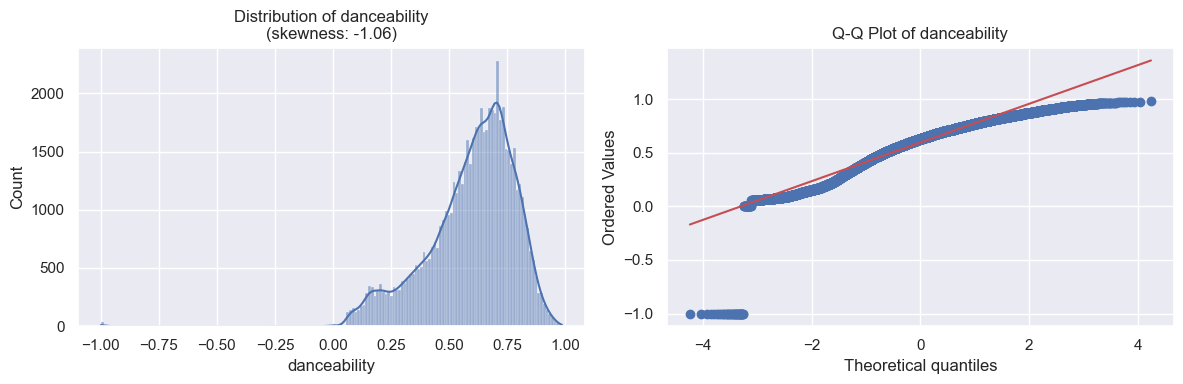


Testing normality for danceability
Sample size: 62317
Range: -1.0 to 0.986
Mean: 0.60, Std: 0.19
Shapiro test statistic: 0.9430, p-value: 3.2806e-40

Data is not normally distributed. Trying transformations...

Trying log transformation...
log transformation p-value: 1.9115e-98

Trying sqrt transformation...
sqrt transformation p-value: 7.1609e-96

Trying box-cox transformation...
box-cox transformation p-value: 1.4388e-46

Trying yeo-johnson transformation...
yeo-johnson transformation p-value: 7.0754e-48
Best transformation: original (p-value: 3.2806e-40)

Analyzing duration_ms...

Original distribution:


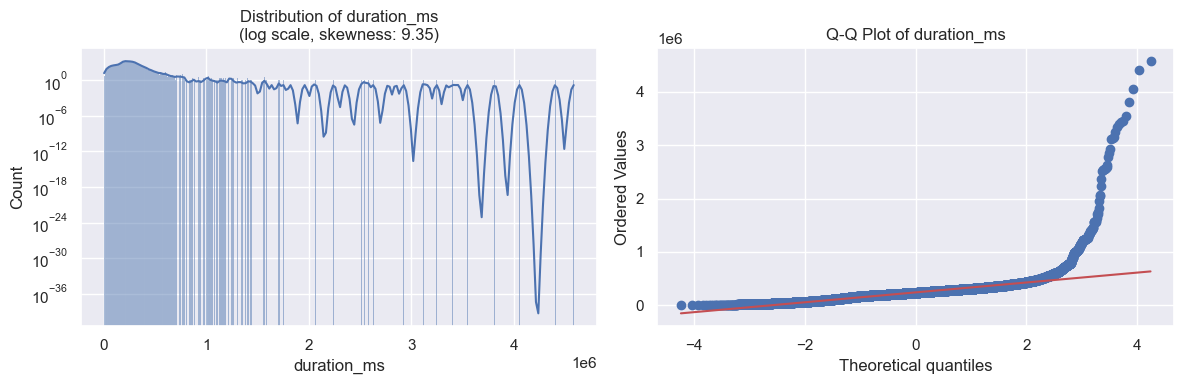


Testing normality for duration_ms
Sample size: 62317
Range: 5000.0 to 4581483.0
Mean: 242527.04, Std: 112999.93
Shapiro test statistic: 0.5523, p-value: 8.8651e-78

Data is not normally distributed. Trying transformations...

Trying log transformation...
log transformation p-value: 2.1181e-105

Trying sqrt transformation...
sqrt transformation p-value: 4.4181e-100

Trying box-cox transformation...
box-cox transformation p-value: 4.3806e-96

Trying yeo-johnson transformation...
yeo-johnson transformation p-value: 4.3819e-96
Best transformation: original (p-value: 8.8651e-78)

Analyzing energy...

Original distribution:


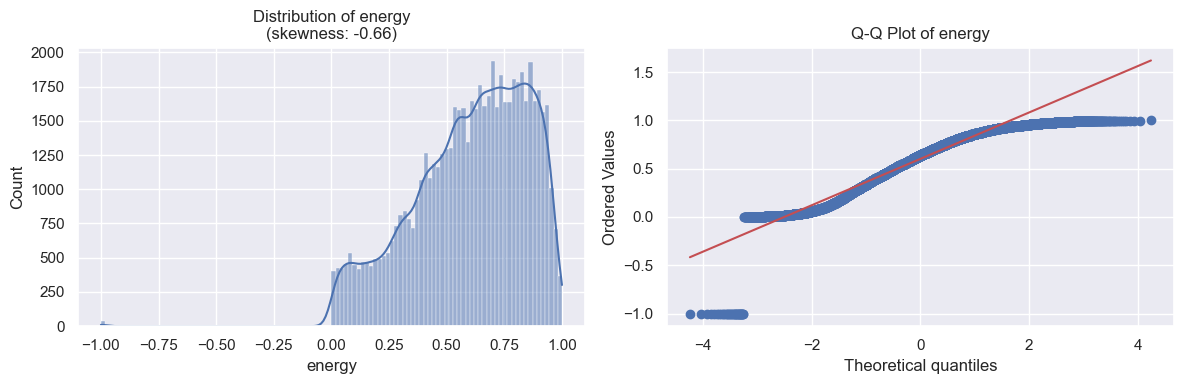


Testing normality for energy
Sample size: 62317
Range: -1.0 to 1.0
Mean: 0.60, Std: 0.25
Shapiro test statistic: 0.9549, p-value: 9.6923e-37

Data is not normally distributed. Trying transformations...

Trying log transformation...
log transformation p-value: 7.8163e-91

Trying sqrt transformation...
sqrt transformation p-value: 1.3276e-88

Trying box-cox transformation...
box-cox transformation p-value: 3.7606e-68

Trying yeo-johnson transformation...
yeo-johnson transformation p-value: 7.6453e-69
Best transformation: original (p-value: 9.6923e-37)

Analyzing instrumentalness...

Original distribution:


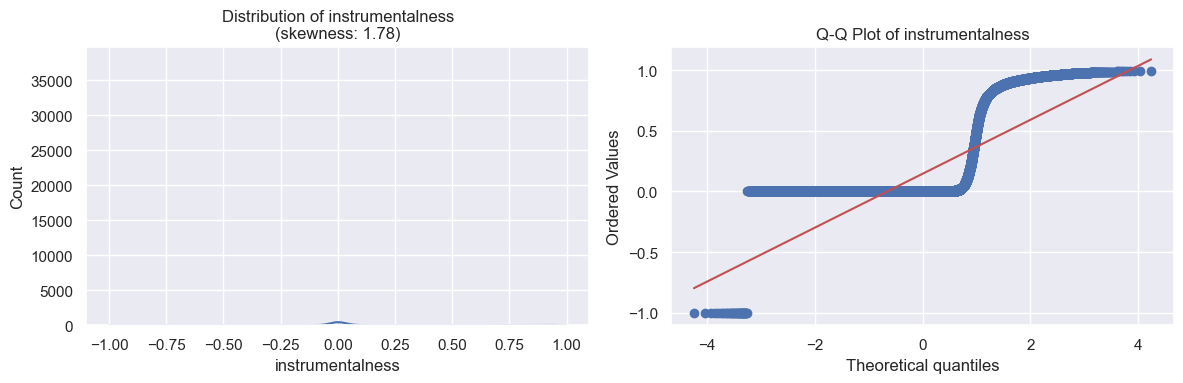


Testing normality for instrumentalness
Sample size: 62317
Range: -1.0 to 0.999
Mean: 0.15, Std: 0.31
Shapiro test statistic: 0.5214, p-value: 3.3028e-79

Data is not normally distributed. Trying transformations...

Trying log transformation...
log transformation p-value: 3.6773e-146

Trying sqrt transformation...
sqrt transformation p-value: 3.2676e-146

Trying box-cox transformation...
box-cox transformation p-value: 1.7554e-148

Trying yeo-johnson transformation...
yeo-johnson transformation p-value: 2.4413e-149
Best transformation: original (p-value: 3.3028e-79)

Analyzing key...

Original distribution:


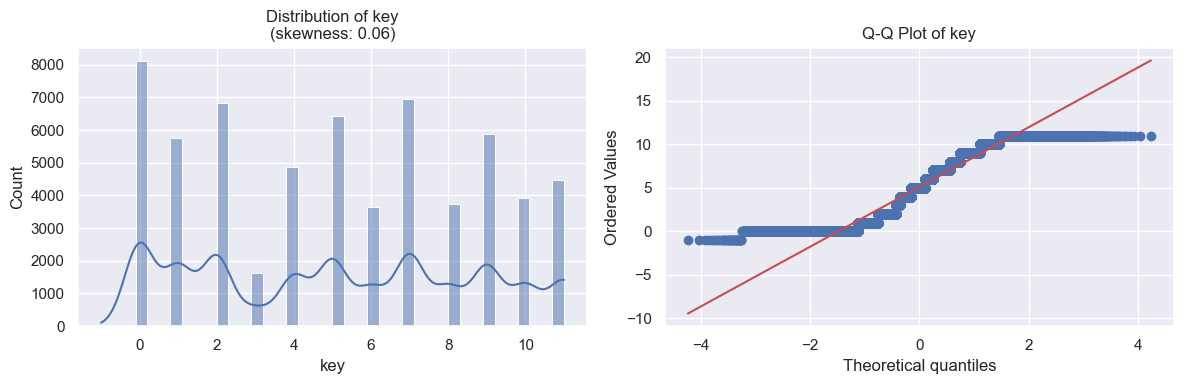


Testing normality for key
Sample size: 62317
Range: -1.0 to 11.0
Mean: 5.10, Std: 3.55
Shapiro test statistic: 0.9325, p-value: 7.8594e-43

Data is not normally distributed. Trying transformations...

Trying log transformation...
log transformation p-value: 1.7873e-100

Trying sqrt transformation...
sqrt transformation p-value: 5.1065e-95

Trying box-cox transformation...
box-cox transformation p-value: 7.7197e-94

Trying yeo-johnson transformation...
yeo-johnson transformation p-value: 4.2845e-94
Best transformation: original (p-value: 7.8594e-43)

Analyzing liveness...

Original distribution:


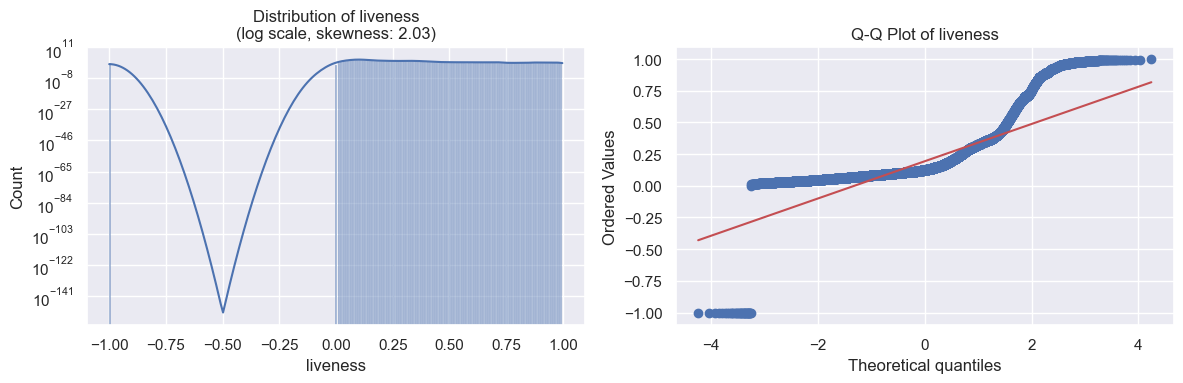


Testing normality for liveness
Sample size: 62317
Range: -1.0 to 0.998
Mean: 0.19, Std: 0.17
Shapiro test statistic: 0.7340, p-value: 4.2663e-67

Data is not normally distributed. Trying transformations...

Trying log transformation...
log transformation p-value: 2.8761e-127

Trying sqrt transformation...
sqrt transformation p-value: 8.5401e-128

Trying box-cox transformation...
box-cox transformation p-value: 1.3941e-128

Trying yeo-johnson transformation...
yeo-johnson transformation p-value: 2.8505e-128
Best transformation: original (p-value: 4.2663e-67)

Analyzing loudness...

Original distribution:


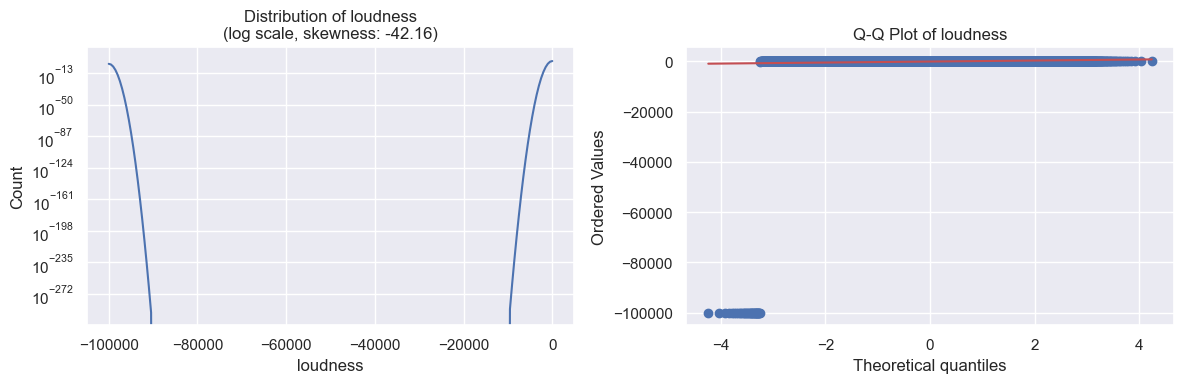


Testing normality for loudness
Sample size: 62317
Range: -100000.0 to 1.233
Mean: -65.10, Std: 2369.05
Shapiro test statistic: 0.0058, p-value: 1.0246e-95

Data is not normally distributed. Trying transformations...

Trying log transformation...
log transformation p-value: 3.3024e-170

Trying sqrt transformation...
sqrt transformation p-value: 3.3391e-170

Trying box-cox transformation...
box-cox transformation p-value: 5.6945e-169

Trying yeo-johnson transformation...
yeo-johnson transformation p-value: 3.7204e-65
Best transformation: yeo-johnson (p-value: 3.7204e-65)

Transformed distribution:


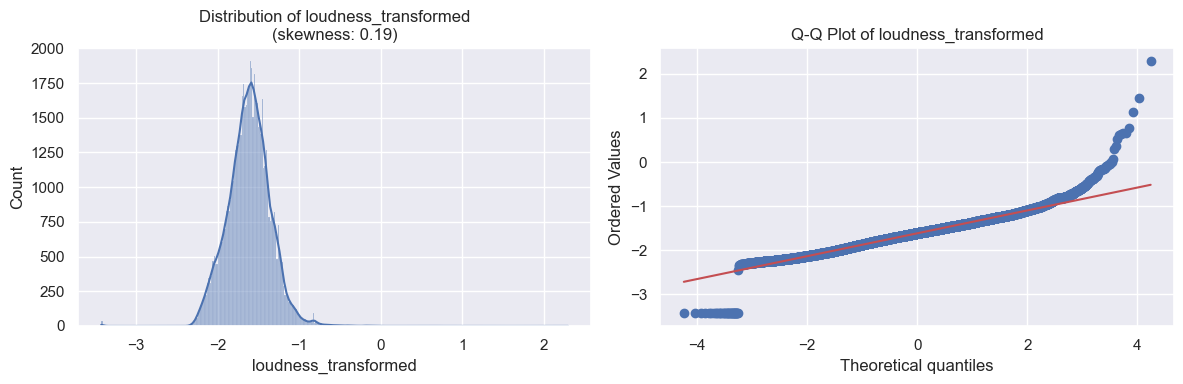


Analyzing mode...

Original distribution:


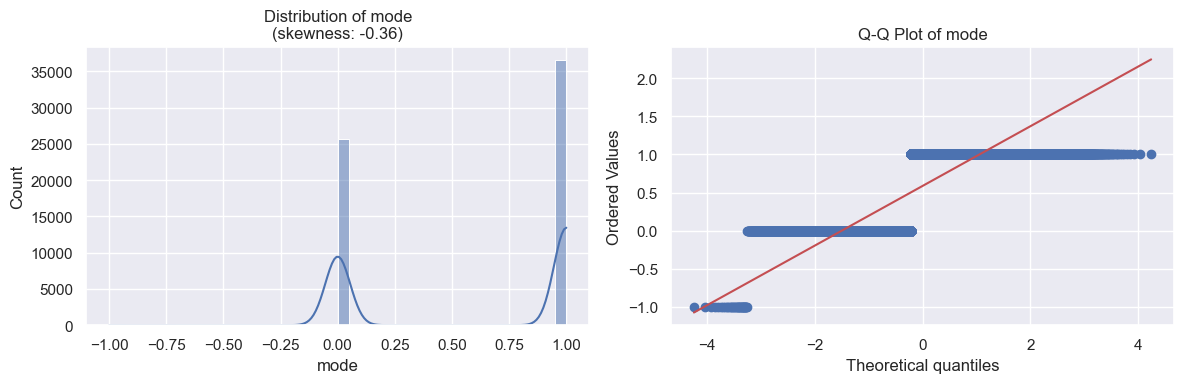


Testing normality for mode
Sample size: 62317
Range: -1.0 to 1.0
Mean: 0.59, Std: 0.49
Shapiro test statistic: 0.6268, p-value: 5.9199e-74

Data is not normally distributed. Trying transformations...

Trying log transformation...
log transformation p-value: 1.0644e-138

Trying sqrt transformation...
sqrt transformation p-value: 1.0488e-138

Trying box-cox transformation...
box-cox transformation p-value: 7.4294e-139

Trying yeo-johnson transformation...
yeo-johnson transformation p-value: 8.3821e-139
Best transformation: original (p-value: 5.9199e-74)

Analyzing speechiness...

Original distribution:


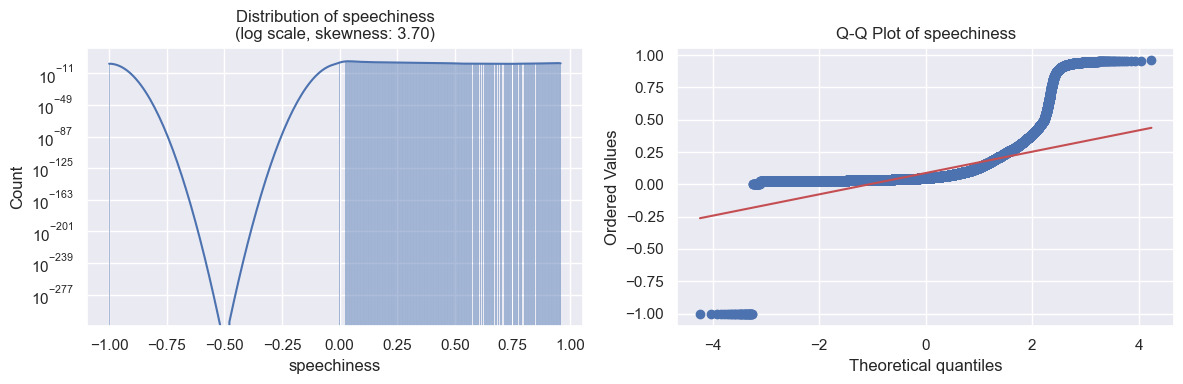


Testing normality for speechiness
Sample size: 62317
Range: -1.0 to 0.959
Mean: 0.09, Std: 0.12
Shapiro test statistic: 0.5096, p-value: 9.9329e-80

Data is not normally distributed. Trying transformations...

Trying log transformation...
log transformation p-value: 6.3852e-146

Trying sqrt transformation...
sqrt transformation p-value: 3.1203e-146

Trying box-cox transformation...
box-cox transformation p-value: 1.4631e-146

Trying yeo-johnson transformation...
yeo-johnson transformation p-value: 2.6714e-146
Best transformation: original (p-value: 9.9329e-80)

Analyzing tempo...

Original distribution:


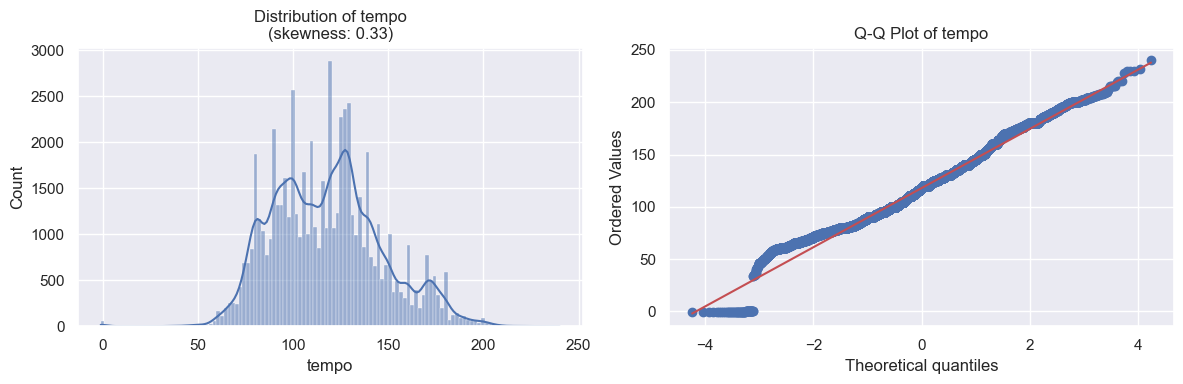


Testing normality for tempo
Sample size: 62317
Range: -1.0 to 239.97
Mean: 117.93, Std: 28.51
Shapiro test statistic: 0.9850, p-value: 1.2252e-22

Data is not normally distributed. Trying transformations...

Trying log transformation...
log transformation p-value: 3.7730e-109

Trying sqrt transformation...
sqrt transformation p-value: 6.0649e-65

Trying box-cox transformation...
box-cox transformation p-value: 1.5198e-55

Trying yeo-johnson transformation...
yeo-johnson transformation p-value: 9.8713e-56
Best transformation: original (p-value: 1.2252e-22)

Analyzing time_signature...

Original distribution:


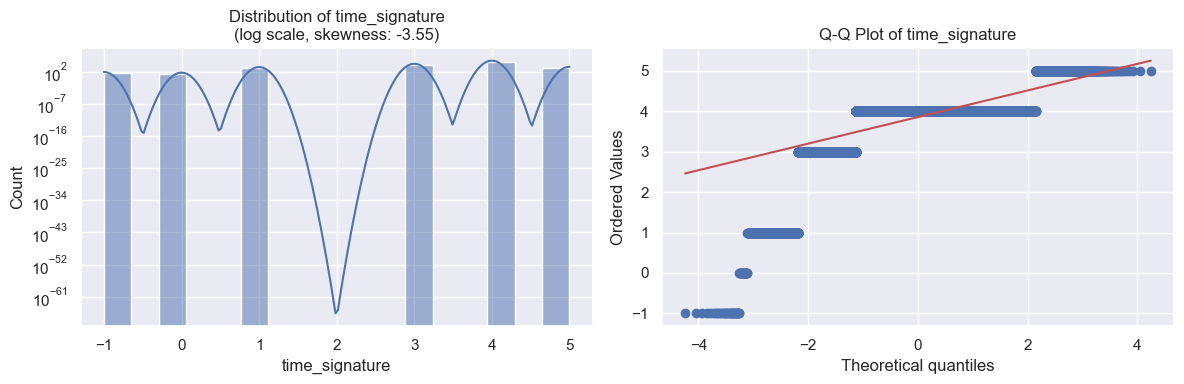


Testing normality for time_signature
Sample size: 62317
Range: -1.0 to 5.0
Mean: 3.86, Std: 0.50
Shapiro test statistic: 0.4390, p-value: 1.1721e-82

Data is not normally distributed. Trying transformations...

Trying log transformation...
log transformation p-value: 6.8487e-155

Trying sqrt transformation...
sqrt transformation p-value: 9.5359e-154

Trying box-cox transformation...
box-cox transformation p-value: 9.3527e-150

Trying yeo-johnson transformation...
yeo-johnson transformation p-value: 1.0442e-149
Best transformation: original (p-value: 1.1721e-82)

Analyzing valence...

Original distribution:


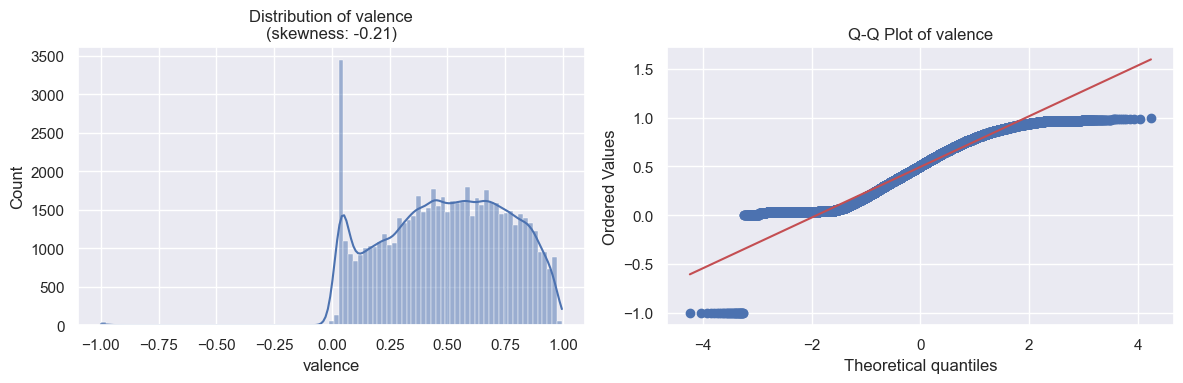


Testing normality for valence
Sample size: 62317
Range: -1.0 to 0.995
Mean: 0.50, Std: 0.26
Shapiro test statistic: 0.9664, p-value: 1.2503e-32

Data is not normally distributed. Trying transformations...

Trying log transformation...
log transformation p-value: 1.3338e-81

Trying sqrt transformation...
sqrt transformation p-value: 5.7293e-80

Trying box-cox transformation...
box-cox transformation p-value: 6.8375e-74

Trying yeo-johnson transformation...
yeo-johnson transformation p-value: 2.7175e-74
Best transformation: original (p-value: 1.2503e-32)


In [5]:
results = []

for column in numeric_cols:
    print(f"\n{'='*50}")
    print(f"Analyzing {column}...")
    
    try:
        if df[column].nunique() <= 1:
            print(f"Skipping {column} - not enough unique values")
            continue
            
        if df[column].isnull().all():
            print(f"Skipping {column} - all values are null")
            continue
        
        print("\nOriginal distribution:")
        plot_distribution_and_qq(df, column)
        
        p_value = test_normality(df, column)
        
        if p_value < 0.05:
            print("\nData is not normally distributed. Trying transformations...")
            best_transform, transformed_data = suggest_transformation(df, column, p_value)
            print(f"Best transformation: {best_transform[0]} (p-value: {best_transform[1]:.4e})")
            
            if transformed_data is not None:
                temp_df = pd.DataFrame({f"{column}_transformed": transformed_data})
                print("\nTransformed distribution:")
                plot_distribution_and_qq(temp_df, f"{column}_transformed")
        else:
            print("\nData is normally distributed!")
        
        results.append({
            'column': column,
            'original_p_value': p_value,
            'needs_transformation': p_value < 0.05,
            'best_transformation': best_transform[0] if p_value < 0.05 else 'none',
            'transformed_p_value': best_transform[1] if p_value < 0.05 else p_value
        })
    except Exception as e:
        print(f"Error analyzing {column}: {str(e)}")

### Summary of Results

In [6]:
results_df = pd.DataFrame(results)
print("Summary of normality analysis:")
display(results_df)

Summary of normality analysis:


,column,original_p_value,needs_transformation,best_transformation,transformed_p_value
0,year,1.045060e-57,True,original,1.045060e-57
1,popularity,1.152609e-60,True,original,1.152609e-60
2,acousticness,9.309997e-49,True,original,9.309997e-49
3,danceability,3.280585e-40,True,original,3.280585e-40
4,duration_ms,8.865148e-78,True,original,8.865148e-78
5,energy,9.692296e-37,True,original,9.692296e-37
6,instrumentalness,3.302770e-79,True,original,3.302770e-79
7,key,7.859441e-43,True,original,7.859441e-43
8,liveness,4.266272e-67,True,original,4.266272e-67
9,loudness,1.024585e-95,True,yeo-johnson,3.720433e-65
